<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/RegulomeExplorer/Comparing_protein_expression_from_different_pipelines_CPTAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing protein expression from different pipelines - CPTAC

Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

```
Title:   Comparing protein expression from different pipelines 
Author:  Boris Aguilar
Created: 05-23-2021
Purpose: Compare proteomic expression from PDC and other pipelines available in the cptac library (https://github.com/PayneLab/cptac)
Notes: Runs in Google Colab   
```
This notebook uses BigQuery to compare protein expression from the PDC and other pipelines. We used the [cptac library](https://github.com/PayneLab/cptac) to obtain protein expression derived from pipelines different than the one used by PDC.


# Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.colab import auth
import pandas_gbq

## Google Authentication
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

Moreover you need to [create a google cloud](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console) project to be able to run BigQuery queries.

In [2]:
auth.authenticate_user()
my_project_id = "" # write your project id here
bqclient = bigquery.Client( my_project_id )

## Install cptac library

In [3]:
try:
    import cptac
except ImportError:
    !pip install cptac --quiet
    import cptac
import cptac.utils as ut

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Use the cptac library to download proteomic data of Lung adenocarcinoma (LUAD) and save it into a pandas dataframe.

In [4]:
cptac.download(dataset="Luad", version="latest")
ov = cptac.Luad()
df = ov.get_proteomics( )
df

Name               A1BG  ...                       ZZZ3
Database_ID NP_570602.2  ... NP_056349.1|NP_001295166.1
Patient_ID               ...                           
C3L-00001       -2.5347  ...                    -2.5284
C3L-00009       -0.5627  ...                     0.4311
C3L-00080       -1.9422  ...                    -0.7301
C3L-00083        2.1636  ...                        NaN
C3L-00093       -1.0022  ...                    -0.3077
...                 ...  ...                        ...
C3N-02582.N      1.8277  ...                     0.9497
C3N-02586.N      0.8035  ...                     1.1807
C3N-02587.N      1.7637  ...                     1.1825
C3N-02588.N      1.0875  ...                     1.2729
C3N-02729.N      2.6011  ...                     0.8390

[211 rows x 10699 columns]

## From dataframe to BigQuery table
The following commands transform the dataframe to a tidy format and save it into a BigQuery table in your project.

In [5]:
tdf =  pd.melt(df, var_name="gene_name", value_name="protein_abundance",ignore_index = False)
tdf.reset_index(inplace=True)
tdf[0:10]

,Patient_ID,gene_name,protein_abundance
0,C3L-00001,A1BG,-2.5347
1,C3L-00009,A1BG,-0.5627
2,C3L-00080,A1BG,-1.9422
3,C3L-00083,A1BG,2.1636
4,C3L-00093,A1BG,-1.0022
5,C3L-00094,A1BG,-1.5576
6,C3L-00095,A1BG,-1.0718
7,C3L-00140,A1BG,-1.0799
8,C3L-00144,A1BG,-1.9159
9,C3L-00263,A1BG,-1.1384


The following commands send the protein expression data to a BigQuery table.

In [6]:
table_id = 'test_dataset2.luad_cptac_paynelab' # test_dataset2 is dataset and luad_cptac_paynelab is the table name
pandas_gbq.to_gbq(tdf, table_id, project_id=my_project_id)

## Compute Pearson correlations in BigQuery
Here we compare protein expressions from the cptac library with those generated from PDC proteomics data. The comparison is made by computing Pearson correlation. 

The first step is to build a query to retrieve PDC based protein expressions, which are available in BigQuery tables in the public project isb-cgc-bq.

In [7]:
pdc = '''
With pdc AS (
    SELECT meta.case_submitter_id, quant.gene_symbol, 
           CAST(quant.protein_abundance_log2ratio AS FLOAT64) AS protein_abundance_log2ratio
    FROM `isb-cgc-bq.CPTAC.quant_proteome_CPTAC_LUAD_discovery_study_pdc_current` as quant
    JOIN `isb-cgc-bq.PDC_metadata.aliquot_to_case_mapping_current` as meta
        ON quant.case_id = meta.case_id
        AND quant.aliquot_id = meta.aliquot_id
        AND meta.sample_type = 'Primary Tumor'
)
'''

The following query combines the pdc and cptac data:

In [8]:
cptac = '''
qdata AS (
  SELECT pdc.case_submitter_id, pdc.gene_symbol, pdc.protein_abundance_log2ratio,
        cptac.protein_abundance
  FROM pdc 
  JOIN `{0}.{1}` as cptac 
    ON pdc.case_submitter_id = cptac.Patient_ID
    AND pdc.gene_symbol = cptac.gene_name
)
'''.format(my_project_id, table_id)

Finally we compute Pearson correlations.

In [9]:
mysql = (pdc + ',' + cptac + '''
SELECT gene_symbol, count(*) as N, corr(protein_abundance_log2ratio,protein_abundance) as Correlations
FROM qdata 
WHERE NOT IS_NAN(protein_abundance_log2ratio)
      AND NOT IS_NAN(protein_abundance) 
GROUP BY gene_symbol
HAVING N >= 20 
ORDER BY Correlations DESC
''' )

df1 = pandas_gbq.read_gbq(mysql,project_id=my_project_id )
df1

Downloading: 100%|██████████| 9650/9650 [00:00<00:00, 25317.80rows/s]


,gene_symbol,N,Correlations
0,GLYATL2,21,0.990671
1,SLC2A10,49,0.989670
2,TNC,108,0.983017
3,BCAS1,104,0.980725
4,SLC27A2,108,0.980098
...,...,...,...
9645,SACS,108,-0.166687
9646,SLC38A9,30,-0.303329
9647,SASS6,27,-0.329240
9648,SPEF2,30,-0.382587


## Histogram of correlations
The results above show the correlation between PDC and cptac protein expressions for 9650 proteins. Next we show a histogram of these correlations.

(-1.0, 1.1)

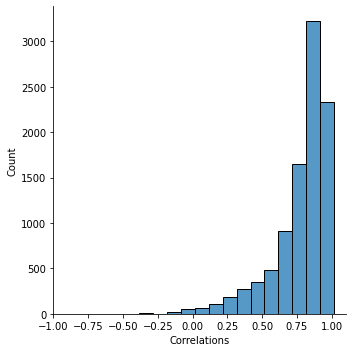

In [10]:
sns.displot(data=df1, x="Correlations", binwidth=0.1)
plt.xlim(-1.0, 1.1)

The histogram shows that the two pipelines used in this analysis produced similar protein expression for most genes.